# Extended MNIST

## Initialization

In [1]:
# Import basic libraries
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import keras_tuner as kt

# Set seed
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Read dataset
df = pd.read_csv("emnist-letters.csv")

# Reshape to images
X = df.iloc[:,1:].to_numpy().reshape(-1, 28, 28, order="F")
y = df.iloc[:,0].to_numpy()-1
# Split dataset in training and testing (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split training test in training and validation (75% of 80% in training and 25% of 80% in validation)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Normalize (to have values between 0 and 1)
X_train = X_train.astype("float32") / 255.
X_valid = X_valid.astype("float32") / 255.
X_test = X_test.astype("float32") / 255.

# Set with single channel (used by CNN)
X_train_cnn = X_train.reshape(-1, 28, 28, 1)
X_valid_cnn = X_valid.reshape(-1, 28, 28, 1)
X_test_cnn = X_test.reshape(-1, 28, 28, 1)

# Set with training and validation (used when training the final model)
X_train_final = np.concatenate((X_train, X_valid))
X_train_cnn_final = X_train_final.reshape(-1, 28, 28, 1)
y_train_final = np.concatenate((y_train, y_valid))

# Dataset is split: 60% in training, 20% in validation and 20% in testing
print(f"Dataset size: {df.shape[0]}; Training size: {X_train.shape[0]}; Validation size: {X_valid.shape[0]}; Testing size: {X_test.shape[0]}")

# Helper function to plot model history (used to determine the number of epochs)
def plot_history(history):
  pd.DataFrame(history.history).plot(figsize=(8, 5))
  plt.grid(True)
  plt.gca().set_ylim(0, 1)
  plt.show()

Dataset size: 88799; Training size: 53279; Validation size: 17760; Testing size: 17760


## LeNet-5

Adapted version of LeNet-5 (using ReLU as activation function, and 26 units in output layer)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 5, 5, 16)         0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dense (Dense)               (None, 120)               4

2024-01-18 12:26:50.740653: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
1665/1665 [==============================] - 21s 12ms/step - loss: 0.7414 - accuracy: 0.7723 - val_loss: 0.4222 - val_accuracy: 0.8640
Epoch 2/50
1665/1665 [==============================] - 22s 13ms/step - loss: 0.3441 - accuracy: 0.8864 - val_loss: 0.3240 - val_accuracy: 0.8939
Epoch 3/50
1665/1665 [==============================] - 21s 13ms/step - loss: 0.2762 - accuracy: 0.9069 - val_loss: 0.3131 - val_accuracy: 0.9002
Epoch 4/50
1665/1665 [==============================] - 22s 14ms/step - loss: 0.2373 - accuracy: 0.9193 - val_loss: 0.2541 - val_accuracy: 0.9173
Epoch 5/50
1665/1665 [==============================] - 20s 12ms/step - loss: 0.2112 - accuracy: 0.9260 - val_loss: 0.2480 - val_accuracy: 0.9211
Epoch 6/50
1665/1665 [==============================] - 23s 14ms/step - loss: 0.1914 - accuracy: 0.9321 - val_loss: 0.2513 - val_accuracy: 0.9188
Epoch 7/50
1665/1665 [==============================] - 22s 13ms/step - loss: 0.1760 - accuracy: 0.9367 - val_loss: 0.2383 -

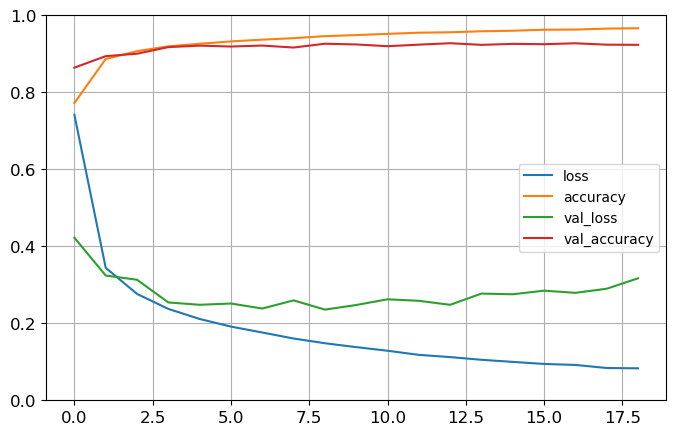

In [2]:
lenet = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(filters=6, kernel_size=5, activation='relu', padding='same', input_shape=(28, 28, 1)),
            tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
            tf.keras.layers.Conv2D(filters=16, kernel_size=5,activation='relu'),
            tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(120, activation='relu'),
            tf.keras.layers.Dense(84, activation='relu'),
            tf.keras.layers.Dense(26, activation="softmax")])

lenet.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

lenet.summary()

history_lenet = lenet.fit(X_train_cnn, y_train, epochs=50,
                          validation_data=(X_valid_cnn, y_valid),
                          callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])

plot_history(history_lenet)

In [3]:
epochs = 7
# Retrain on all the training set
final_lenet = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(filters=6, kernel_size=5, activation='relu', padding='same', input_shape=(28, 28, 1)),
            tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
            tf.keras.layers.Conv2D(filters=16, kernel_size=5,activation='relu'),
            tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(120, activation='relu'),
            tf.keras.layers.Dense(84, activation='relu'),
            tf.keras.layers.Dense(26, activation="softmax")])

final_lenet.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

final_lenet.summary()

final_lenet.fit(X_train_cnn_final, y_train_final, epochs=epochs)

# Evaluate with testing set
results = final_lenet.evaluate(X_test_cnn, y_test)
print(f'Test Loss: {results[0]}; Test Accuracy: {results[1]}')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d_2 (Averag  (None, 14, 14, 6)        0         
 ePooling2D)                                                     
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_3 (Averag  (None, 5, 5, 16)         0         
 ePooling2D)                                                     
                                                                 
 flatten_1 (Flatten)         (None, 400)               0         
                                                                 
 dense_3 (Dense)             (None, 120)              

2024-01-18 12:42:31.921078: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 222778304 exceeds 10% of free system memory.


2220/2220 [==============================] - 12s 5ms/step - loss: 0.6591 - accuracy: 0.7961
Epoch 2/7
2220/2220 [==============================] - 13s 6ms/step - loss: 0.3088 - accuracy: 0.8987
Epoch 3/7
2220/2220 [==============================] - 14s 6ms/step - loss: 0.2523 - accuracy: 0.9153
Epoch 4/7
2220/2220 [==============================] - 14s 6ms/step - loss: 0.2193 - accuracy: 0.9260
Epoch 5/7
2220/2220 [==============================] - 14s 6ms/step - loss: 0.1961 - accuracy: 0.9326
Epoch 6/7
2220/2220 [==============================] - 14s 6ms/step - loss: 0.1777 - accuracy: 0.9370
Epoch 7/7
555/555 [==============================] - 2s 3ms/step - loss: 0.2231 - accuracy: 0.9270
Test Loss: 0.22308824956417084; Test Accuracy: 0.9269707202911377


## Neural Network

In [2]:
def build_model(hp):
  model = tf.keras.models.Sequential()
  # input layer (flatten images to uni-dimensional vector)
  model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))

  # choose dropout rate in range [0.1, 0.3]
  dropoutRate1 = hp.Float('dropoutRate1', min_value=0.1, max_value=0.3, step=0.1)
  dropoutRate2 = hp.Float('dropoutRate2', min_value=0.1, max_value=0.3, step=0.1)
  dropoutRate3 = hp.Float('dropoutRate3', min_value=0.1, max_value=0.3, step=0.1)
  # decide whether to add dropout
  if hp.Boolean('dropout'):
    model.add(tf.keras.layers.Dropout(rate=dropoutRate1))
  
  # add hidden layer
  model.add(tf.keras.layers.Dense(
    units=hp.Int('units1', min_value=50, max_value=300, step=10),
    activation=hp.Choice('activation', ['relu', 'leaky_relu', 'tanh']),
  ))

  if hp.Boolean('dropout2'):
    model.add(tf.keras.layers.Dropout(rate=dropoutRate2))

  if hp.Boolean('layer2'):
    model.add(tf.keras.layers.Dense(
      units=hp.Int('units2', min_value=20, max_value=100, step=10),
      activation=hp.Choice('activation', ['relu', 'leaky_relu', 'tanh'])
    ))

  if hp.Boolean('dropout3'):
    model.add(tf.keras.layers.Dropout(rate=dropoutRate3))
  
  if hp.Boolean('layer3'):
    model.add(tf.keras.layers.Dense(
      units=hp.Int('units3', min_value=10, max_value=50, step=10),
      activation=hp.Choice('activation', ['relu', 'leaky_relu', 'tanh'])
    ))

  # output layer
  model.add(tf.keras.layers.Dense(26, activation='softmax'))
  model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
  )
  return model

In [3]:
tuner = kt.Hyperband(
  hypermodel=build_model,
  objective='val_accuracy',
  overwrite=True,
  directory='/tmp/emnist',
  project_name='emnist-nn',
  seed=42
)

tuner.search_space_summary()

tuner.search(X_train, y_train, 
             validation_data=(X_valid, y_valid),
             epochs=50,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])

Trial 254 Complete [00h 02m 04s]
val_accuracy: 0.8751125931739807

Best val_accuracy So Far: 0.9070382714271545
Total elapsed time: 02h 18m 32s


In [4]:
# Best hyper-parameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)

{'dropoutRate1': 0.2, 'dropoutRate2': 0.2, 'dropoutRate3': 0.1, 'dropout': True, 'units1': 220, 'activation': 'relu', 'dropout2': True, 'layer2': True, 'dropout3': True, 'layer3': True, 'units2': 70, 'units3': 50, 'tuner/epochs': 100, 'tuner/initial_epoch': 34, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0239'}


Epoch 1/100
1665/1665 [==============================] - 6s 3ms/step - loss: 1.1806 - accuracy: 0.6428 - val_loss: 0.6193 - val_accuracy: 0.8077
Epoch 2/100
1665/1665 [==============================] - 5s 3ms/step - loss: 0.6943 - accuracy: 0.7820 - val_loss: 0.4717 - val_accuracy: 0.8542
Epoch 3/100
1665/1665 [==============================] - 5s 3ms/step - loss: 0.5868 - accuracy: 0.8131 - val_loss: 0.4255 - val_accuracy: 0.8678
Epoch 4/100
1665/1665 [==============================] - 5s 3ms/step - loss: 0.5296 - accuracy: 0.8288 - val_loss: 0.3875 - val_accuracy: 0.8773
Epoch 5/100
1665/1665 [==============================] - 5s 3ms/step - loss: 0.4935 - accuracy: 0.8390 - val_loss: 0.3913 - val_accuracy: 0.8753
Epoch 6/100
1665/1665 [==============================] - 5s 3ms/step - loss: 0.4661 - accuracy: 0.8478 - val_loss: 0.3632 - val_accuracy: 0.8833
Epoch 7/100
1665/1665 [==============================] - 5s 3ms/step - loss: 0.4490 - accuracy: 0.8538 - val_loss: 0.3503 - val_ac

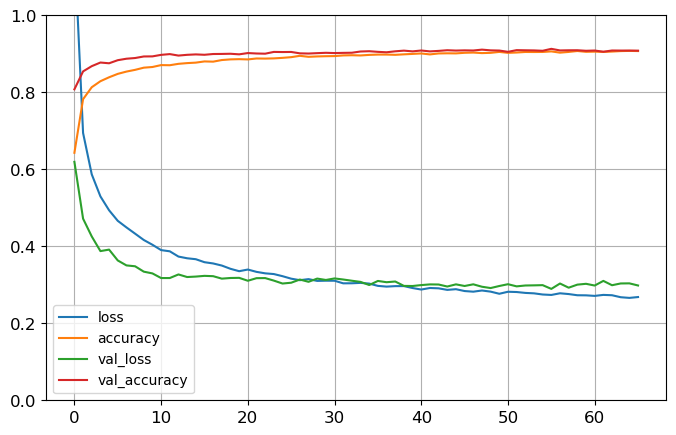

In [8]:
model = tuner.hypermodel.build(best_hps)
history_nn = model.fit(X_train, y_train, 
                       validation_data=(X_valid, y_valid),
                       epochs=100,
                       callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])
plot_history(history_nn)

In [12]:
epochs = 66

# Build final NN
nn_final = tf.keras.models.Sequential()
nn_final.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
nn_final.add(tf.keras.layers.Dropout(rate=0.2))
nn_final.add(tf.keras.layers.Dense(220, activation="relu", kernel_initializer=tf.keras.initializers.HeNormal(seed=42)))
nn_final.add(tf.keras.layers.Dropout(rate=0.2))
nn_final.add(tf.keras.layers.Dense(70, activation="relu", kernel_initializer=tf.keras.initializers.HeNormal(seed=42)))
nn_final.add(tf.keras.layers.Dropout(rate=0.1))
nn_final.add(tf.keras.layers.Dense(50, activation="relu", kernel_initializer=tf.keras.initializers.HeNormal(seed=42)))
nn_final.add(tf.keras.layers.Dense(26, activation="softmax", kernel_initializer=tf.keras.initializers.HeNormal(seed=42)))

nn_final.summary()
nn_final.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])
nn_final.fit(X_train_final, y_train_final, epochs=epochs)

# Evaluate with testing set
results = nn_final.evaluate(X_test, y_test)
print(f'Test Loss: {results[0]}; Test Accuracy: {results[1]}')


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_8 (Flatten)         (None, 784)               0         
                                                                 
 dropout_22 (Dropout)        (None, 784)               0         
                                                                 
 dense_30 (Dense)            (None, 220)               172700    
                                                                 
 dropout_23 (Dropout)        (None, 220)               0         
                                                                 
 dense_31 (Dense)            (None, 70)                15470     
                                                                 
 dropout_24 (Dropout)        (None, 70)                0         
                                                                 
 dense_32 (Dense)            (None, 50)               

## Convolutional Neural Network (custom)

In [2]:
def build_cnn_model(hp):
  activation = hp.Choice('activation', ['relu', 'leaky_relu', 'tanh'])
  
  model = tf.keras.models.Sequential()
  
  filters1 = hp.Int('filters1', min_value=1, max_value=10, step=1)
  kernel1 = hp.Int('size1', min_value=1, max_value=9, step=2)
  model.add(tf.keras.layers.Conv2D(filters=filters1, kernel_size=kernel1, activation=activation, padding='same', input_shape=(28, 28, 1)))

  stride1 = hp.Int('stride1', min_value=2, max_value=4, step=2)
  if hp.Boolean('avg1'): # choose between max or avg pooling
    model.add(tf.keras.layers.AveragePooling2D(pool_size=stride1, strides=stride1))
  else:
    model.add(tf.keras.layers.MaxPooling2D(pool_size=stride1, strides=stride1))
  
  if hp.Boolean('hidden1'):
    filters2 = hp.Int('filters2', min_value=1, max_value=10, step=1)
    kernel2 = hp.Int('size2', min_value=1, max_value=9, step=2)
    model.add(tf.keras.layers.Conv2D(filters=filters2, kernel_size=kernel2, activation=activation, padding='same'))

    stride2 = hp.Int('stride2', min_value=2, max_value=4, step=2)
    if hp.Boolean('avg2'): # choose between max or avg pooling
      model.add(tf.keras.layers.AveragePooling2D(pool_size=stride2, strides=stride2))
    else:
      model.add(tf.keras.layers.MaxPooling2D(pool_size=stride2, strides=stride2))

  if hp.Boolean('hidden2'):
    filters3 = hp.Int('filters3', min_value=1, max_value=10, step=1)
    kernel3 = hp.Int('size3', min_value=1, max_value=9, step=2)
    model.add(tf.keras.layers.Conv2D(filters=filters3, kernel_size=kernel3, activation=activation, padding='same'))

    stride3 = hp.Int('stride3', min_value=2, max_value=4, step=2)
    if hp.Boolean('avg3'): # choose between max or avg pooling
      model.add(tf.keras.layers.AveragePooling2D(pool_size=stride3, strides=stride3))
    else:
      model.add(tf.keras.layers.MaxPooling2D(pool_size=stride3, strides=stride3))
  
  model.add(tf.keras.layers.Flatten())
  if hp.Boolean('dense'):
    model.add(tf.keras.layers.Dense(
      units=hp.Int('units', min_value=30, max_value=100, step=10),
      activation=hp.Choice('act_dense', ['relu', 'leaky_relu', 'tanh']),
    ))
  model.add(tf.keras.layers.Dense(26, activation='softmax'))

  model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
  )
  return model

In [3]:
cnn_tuner = kt.Hyperband(
  hypermodel=build_cnn_model,
  objective='val_accuracy',
  overwrite=True,
  directory='/tmp/emnist-tuner',
  project_name='emnist-cnn',
  seed=42
)

cnn_tuner.search_space_summary()

cnn_tuner.search(X_train_cnn, y_train,
                 validation_data=(X_valid_cnn, y_valid),
                 epochs=50,
                 callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])

Trial 212 Complete [00h 15m 35s]
val_accuracy: 0.7103603482246399

Best val_accuracy So Far: 0.9210022687911987
Total elapsed time: 04h 28m 11s


In [4]:
# Best hyper-parameters
best_hps_cnn = cnn_tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps_cnn.values)

{'activation': 'leaky_relu', 'filters1': 8, 'size1': 7, 'stride1': 2, 'avg1': True, 'hidden1': False, 'hidden2': True, 'dense': True, 'filters3': 6, 'size3': 7, 'stride3': 2, 'avg3': False, 'units': 60, 'act_dense': 'leaky_relu', 'filters2': 5, 'size2': 7, 'stride2': 4, 'avg2': True, 'tuner/epochs': 34, 'tuner/initial_epoch': 0, 'tuner/bracket': 1, 'tuner/round': 0}


Epoch 1/100
1665/1665 [==============================] - 23s 13ms/step - loss: 1.1716 - accuracy: 0.6444 - val_loss: 0.6715 - val_accuracy: 0.7869
Epoch 2/100
1665/1665 [==============================] - 25s 15ms/step - loss: 0.5691 - accuracy: 0.8219 - val_loss: 0.5091 - val_accuracy: 0.8360
Epoch 3/100
1665/1665 [==============================] - 27s 16ms/step - loss: 0.4541 - accuracy: 0.8544 - val_loss: 0.4533 - val_accuracy: 0.8525
Epoch 4/100
1665/1665 [==============================] - 28s 17ms/step - loss: 0.3948 - accuracy: 0.8737 - val_loss: 0.3743 - val_accuracy: 0.8785
Epoch 5/100
1665/1665 [==============================] - 28s 17ms/step - loss: 0.3546 - accuracy: 0.8848 - val_loss: 0.3438 - val_accuracy: 0.8903
Epoch 6/100
1665/1665 [==============================] - 27s 16ms/step - loss: 0.3272 - accuracy: 0.8950 - val_loss: 0.3266 - val_accuracy: 0.8940
Epoch 7/100
1665/1665 [==============================] - 26s 16ms/step - loss: 0.3080 - accuracy: 0.9013 - val_loss: 0

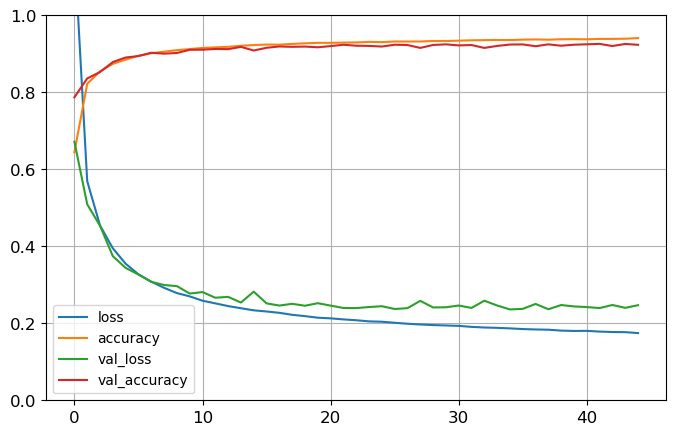

In [17]:
cnn_model = cnn_tuner.hypermodel.build(best_hps_cnn)
history_cnn = cnn_model.fit(X_train_cnn, y_train, 
                       validation_data=(X_valid_cnn, y_valid),
                       epochs=100,
                       callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])
plot_history(history_cnn)

In [6]:
epochs = 45
# Retrain on all the training set
final_cnn = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(filters=8, kernel_size=7, activation='leaky_relu', padding='same', input_shape=(28, 28, 1), kernel_initializer=tf.keras.initializers.HeNormal(seed=42)),
            tf.keras.layers.AveragePooling2D(pool_size=2, strides=2),
            tf.keras.layers.Conv2D(filters=6, kernel_size=7,activation='leaky_relu', kernel_initializer=tf.keras.initializers.HeNormal(seed=42)),
            tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(60, activation='leaky_relu', kernel_initializer=tf.keras.initializers.HeNormal(seed=42)),
            tf.keras.layers.Dense(26, activation="softmax", kernel_initializer=tf.keras.initializers.HeNormal(seed=42))])

final_cnn.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

final_cnn.summary()

final_cnn.fit(X_train_cnn_final, y_train_final, epochs=epochs)

# Evaluate with testing set
results = final_cnn.evaluate(X_test_cnn, y_test)
print(f'Test Loss: {results[0]}; Test Accuracy: {results[1]}')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 8)         400       
                                                                 
 average_pooling2d_2 (Averag  (None, 14, 14, 8)        0         
 ePooling2D)                                                     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 6)           2358      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 4, 6)          0         
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 96)                0         
                                                                 
 dense_2 (Dense)             (None, 60)               